In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..',))

from calibration import TemperatureScaling
from models.cifar10_models import *
from torchvision.models import resnet50
from utils.dataset_utils import get_subsampled_dataset, get_train_val_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms as T
import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

SEED = 42
NUM_SAMPLES = 10000
ATTACK_SAMPLES = 2500
torch.manual_seed(SEED);

## Stanford Dogs figures

### KDE Top Confidence

In [2]:
transformation = T.Compose([
    T.Resize(224),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

inv_normalization = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

dataset_train = ImageFolder('../data/stanford_dogs/Images', transform=transformation)
train_data, test_data = get_train_val_split(dataset_train, 0.8, seed=SEED)
member_target, member_shadow = get_train_val_split(train_data, 0.5, seed=SEED)
member_target = get_subsampled_dataset(member_target, 2058)
member_shadow = get_subsampled_dataset(member_shadow, 2058)
non_member_target, non_member_shadow =  get_train_val_split(test_data, 0.5, seed=SEED)

afhq_dataset = ImageFolder('../data/afhq/train', transformation)
afhq_dogs = Subset(afhq_dataset, np.where(np.array(afhq_dataset.targets) == 1)[0])
afhq_cats = Subset(afhq_dataset, np.where(np.array(afhq_dataset.targets) == 0)[0])
afhq_cats = get_subsampled_dataset(afhq_cats, len(member_target))

In [3]:
target_model = resnet50(num_classes=120)
shadow_model = resnet50(num_classes=120)
target_model = target_model.cuda()
shadow_model = shadow_model.cuda()
target_model.eval()
shadow_model.eval()
target_model.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_target.pt'))
shadow_model.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_shadow.pt'))

target_model_ls = resnet50(num_classes=120)
shadow_model_ls = resnet50(num_classes=120)
target_model_ls = target_model_ls.cuda()
shadow_model_ls = shadow_model_ls.cuda()
target_model_ls.eval()
shadow_model_ls.eval()
target_model_ls.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_LS_0.1_target.pt'))
shadow_model_ls.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_LS_0.1_shadow.pt'))

target_model_l2 = resnet50(num_classes=120)
shadow_model_l2 = resnet50(num_classes=120)
target_model_l2 = target_model_l2.cuda()
shadow_model_l2 = shadow_model_l2.cuda()
target_model_l2.eval()
shadow_model_l2.eval()
target_model_l2.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_L2_0.001_target.pt'))
shadow_model_l2.load_state_dict(torch.load('../pretrained_models/resnet50_stanford_dogs_L2_0.001_shadow.pt'))

target_model_temp = TemperatureScaling(target_model)
target_model_temp.temperature = 10

In [4]:
confidences = []
labels = []
for dataset, name in zip([member_target, non_member_target, afhq_cats], ['Member', 'Non-Member', 'OOD']):
    labels += [name for i in range(len(dataset))]
    loader = torch.utils.data.DataLoader(dataset, batch_size=80, num_workers=8)
    for x, y in loader:
        with torch.no_grad():
            conf = target_model(x.cuda()).softmax(1)
            conf, _ = torch.topk(conf, 1)
            confidences.append(conf.cpu())
confidences = torch.cat(confidences, dim=0)

In [5]:
confidences_ls = []
labels_ls = []
for dataset, name in zip([member_target, non_member_target, afhq_cats], ['Member', 'Non-Member', 'OOD']):
    labels_ls += [name for i in range(len(dataset))]
    loader = torch.utils.data.DataLoader(dataset, batch_size=80, num_workers=8)
    for x, y in loader:
        with torch.no_grad():
            conf = target_model_ls(x.cuda()).softmax(1)
            conf, _ = torch.topk(conf, 1)
            confidences_ls.append(conf.cpu())
confidences_ls = torch.cat(confidences_ls, dim=0)

In [6]:
confidences_l2 = []
labels_l2 = []
for dataset, name in zip([member_target, non_member_target, afhq_cats], ['Member', 'Non-Member', 'OOD']):
    labels_l2 += [name for i in range(len(dataset))]
    loader = torch.utils.data.DataLoader(dataset, batch_size=80, num_workers=8)
    for x, y in loader:
        with torch.no_grad():
            conf = target_model_l2(x.cuda()).softmax(1)
            conf, _ = torch.topk(conf, 1)
            confidences_l2.append(conf.cpu())
confidences_l2 = torch.cat(confidences_l2, dim=0)

In [7]:
confidences_temp = []
labels_temp = []
for dataset, name in zip([member_target, non_member_target, afhq_cats], ['Member', 'Non-Member', 'OOD']):
    labels_ls += [name for i in range(len(dataset))]
    loader = torch.utils.data.DataLoader(dataset, batch_size=80, num_workers=8)
    for x, y in loader:
        with torch.no_grad():
            conf = target_model_temp(x.cuda())
            conf, _ = torch.topk(conf, 1)
            confidences_temp.append(conf.cpu())
confidences_temp = torch.cat(confidences_temp, dim=0)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-

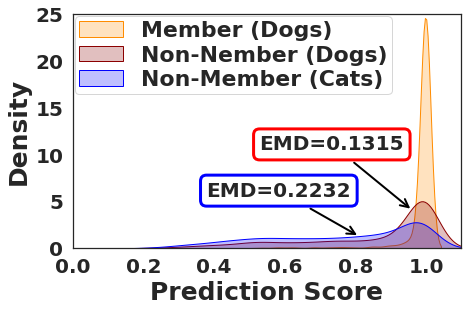

In [17]:
# Plotting the KDE Plot
sns.set(rc={'figure.figsize':(20/3, 4.5)})
sns.set_style("white", {'axes.grid' : False})

plt.xlim(0, 1.1)
plt.ylim(0, 25)
sns.kdeplot(confidences.numpy()[:2058, 0], color='darkorange', shade=True, label='Member (Dogs)')
sns.kdeplot(confidences.numpy()[2058:2*2058, 0], color='darkred', shade=True, label='Non-Nember (Dogs)')
sns.kdeplot(confidences.numpy()[2*2058:3*2058, 0], color='blue', shade=True, label='Non-Member (Cats)')

emd_non_member = wasserstein_distance(confidences.numpy()[0:2058, 0], confidences.numpy()[2058:2*2058, 0])
emd_ood = wasserstein_distance(confidences.numpy()[0:2058, 0], confidences.numpy()[2*2058:3*2058, 0])

plt.annotate(f"EMD={emd_non_member:.4f}", xy=(0.96, 4.1),
            bbox=dict(boxstyle="round", fc="none", ec="red", linewidth=3),
            xytext=(-80, 60), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.annotate(f"EMD={emd_ood:.4f}", xy=(0.81, 1.3),
            bbox=dict(boxstyle="round", fc="none", ec="blue", linewidth=3),
            xytext=(-80, 40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.xlabel('Prediction Score', fontsize=25, fontweight = 'bold')
plt.ylabel('Density', fontsize=25, fontweight = 'bold')
plt.xticks(fontsize=20, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
plt.legend(loc='upper left', prop={'weight':'bold', 'size':22}, labelspacing=0.2, borderpad=0.2, borderaxespad=0.1, frameon=True)

plt.tight_layout()
plt.savefig('kde_standard.pdf', dpi=300)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-

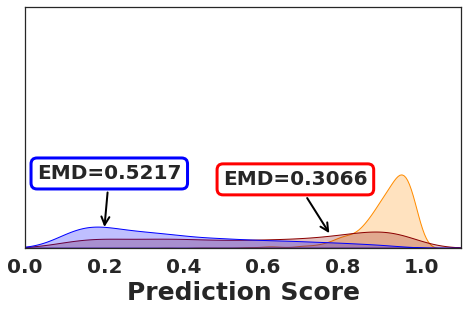

In [18]:
#### Plotting the KDE Plot
sns.set(rc={'figure.figsize':(20/3, 4.5)})
sns.set_style("white", {'axes.grid' : False})

plt.xlim(0, 1.1)
plt.ylim(0, 25)
sns.kdeplot(confidences_ls.numpy()[:2058, 0], color='darkorange', shade=True, label='Member (Stanford Dogs)')
sns.kdeplot(confidences_ls.numpy()[2058:2*2058, 0], color='darkred', shade=True, label='Non-Nember (Stanford Dogs)')
sns.kdeplot(confidences_ls.numpy()[2*2058:3*2058, 0], color='blue', shade=True, label='Non-Member (AFHQ Cats)')

emd_non_member = wasserstein_distance(confidences_ls.numpy()[0:2058, 0], confidences_ls.numpy()[2058:2*2058, 0])
emd_ood = wasserstein_distance(confidences_ls.numpy()[0:2058, 0], confidences_ls.numpy()[2*2058:3*2058, 0])


plt.annotate(f"EMD={emd_non_member:.4f}", xy=(0.77, 1.39),
            bbox=dict(boxstyle="round", fc="none", ec="red", linewidth=3),
            xytext=(-35, 50), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.annotate(f"EMD={emd_ood:.4f}", xy=(0.2, 2),
            bbox=dict(boxstyle="round", fc="none", ec="blue", linewidth=3),
            xytext=(5, 50), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.xlabel('Prediction Score', fontsize=25, fontweight = 'bold')
plt.ylabel('', fontsize=25, fontweight = 'bold')
plt.xticks(fontsize=20, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
plt.gca().axes.yaxis.set_ticks([])

plt.tight_layout()
plt.savefig('kde_smoothing.pdf', dpi=300)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-

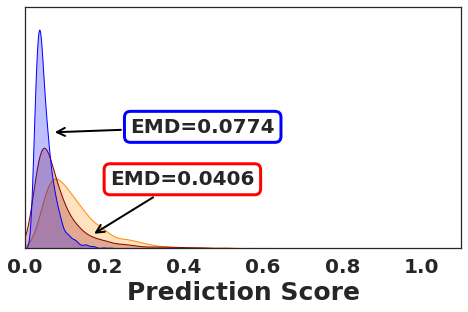

In [19]:
#### Plotting the KDE Plot
sns.set(rc={'figure.figsize':(20/3, 4.5)})
sns.set_style("white", {'axes.grid' : False})

plt.xlim(0, 1.1)
plt.ylim(0, 25)

sns.kdeplot(confidences_temp.numpy()[:2058, 0], color='darkorange', shade=True, label='Member (Stanford Dogs)')
sns.kdeplot(confidences_temp.numpy()[2058:2*2058, 0], color='darkred', shade=True, label='Non-Nember (Stanford Dogs)')
sns.kdeplot(confidences_temp.numpy()[2*2058:3*2058, 0], color='blue', shade=True, label='Non-Member (AFHQ Cats)')

emd_non_member = wasserstein_distance(confidences_temp.numpy()[0:2058, 0], confidences_temp.numpy()[2058:2*2058, 0])
emd_ood = wasserstein_distance(confidences_temp.numpy()[0:2058, 0], confidences_temp.numpy()[2*2058:3*2058, 0])


plt.annotate(f"EMD={emd_non_member:.4f}", xy=(0.17, 1.4),
            bbox=dict(boxstyle="round", fc="none", ec="red", linewidth=3),
            xytext=(90, 50), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.annotate(f"EMD={emd_ood:.4f}", xy=(0.07, 12),
            bbox=dict(boxstyle="round", fc="none", ec="blue", linewidth=3),
            xytext=(150, 0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.xlabel('Prediction Score', fontsize=25, fontweight = 'bold')
plt.ylabel('', fontsize=25, fontweight = 'bold')
plt.xticks(fontsize=20, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
plt.gca().axes.yaxis.set_ticks([])

plt.tight_layout()
plt.savefig('kde_temperature.pdf', dpi=300)


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:949: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:992: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/conda/lib/python3.8/site-

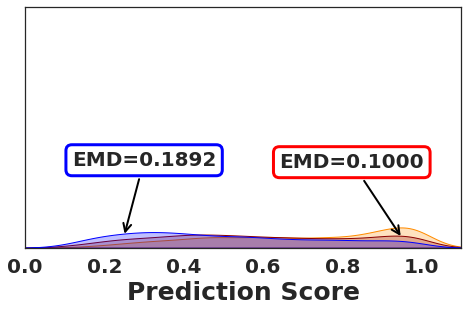

In [20]:
#### Plotting the KDE Plot
sns.set(rc={'figure.figsize':(20/3, 4.5)})
sns.set_style("white", {'axes.grid' : False})

plt.xlim(0, 1.1)
plt.ylim(0, 25)

sns.kdeplot(confidences_l2.numpy()[:2058, 0], color='darkorange', shade=True, label='Member (Stanford Dogs)')
sns.kdeplot(confidences_l2.numpy()[2058:2*2058, 0], color='darkred', shade=True, label='Non-Nember (Stanford Dogs)')
sns.kdeplot(confidences_l2.numpy()[2*2058:3*2058, 0], color='blue', shade=True, label='Non-Member (AFHQ Cats)')

emd_non_member = wasserstein_distance(confidences_l2.numpy()[0:2058, 0], confidences_l2.numpy()[2058:2*2058, 0])
emd_ood = wasserstein_distance(confidences_l2.numpy()[0:2058, 0], confidences_l2.numpy()[2*2058:3*2058, 0])


plt.annotate(f"EMD={emd_non_member:.4f}", xy=(0.95, 1.1),
            bbox=dict(boxstyle="round", fc="none", ec="red", linewidth=3),
            xytext=(-50, 70), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.annotate(f"EMD={emd_ood:.4f}", xy=(0.25, 1.3),
            bbox=dict(boxstyle="round", fc="none", ec="blue", linewidth=3),
            xytext=(20, 70), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=2), fontsize=20, weight='bold')

plt.xlabel('Prediction Score', fontsize=25, fontweight = 'bold')
plt.ylabel('', fontsize=25, fontweight = 'bold')
plt.xticks(fontsize=20, fontweight = 'bold')
plt.yticks(fontsize=20, fontweight = 'bold')
plt.gca().axes.yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('kde_l2_regularizer.pdf', dpi=300)